In [4]:
import pickle as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [119]:
def jaccard_distance(x, y):
    return 1 - len(set(x).intersection(y)) / len(set(x).union(y))

def sort_files(path):
    base, dataset_name, model_name, eps = path.split(sep="/")
    files = []
    for file in os.listdir(path):
        if file.endswith(".pkl"):
            files.append(file)

    LEN_PREFIX = len(model_name)+1
    LEN_SUFFIX = len(".pkl")
    timestamps = [filename[LEN_PREFIX:-LEN_SUFFIX] for filename in files]
    sorted_timestamps = sorted(timestamps)
    sorted_files = [model_name + "-" + timestamp + ".pkl" for timestamp in sorted_timestamps]

    return sorted_files

def _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=None):
    cut = int(len(item_popularity) * 0.8)
    tail_items = set(item_popularity.sort_values(ascending=True).iloc[:cut].index.tolist())

    recall, ndcg, arp, aft = dict(), dict(), dict(), dict()
    for uid, recs in recommendation_list.items():
        if impacted_users is not None:
            if uid not in impacted_users:
                continue

        recall[uid] = len(groundtruth.loc[uid].intersection([str(iid) for iid in recs])) / len(groundtruth.loc[uid])

        dcg = 0.0
        idcg = 0.0
        for pos in range(1, len(recs)+1):
            item_at_i = str(recs[pos-1])
            rel_i = item_at_i in groundtruth.loc[uid]
            dcg += rel_i / np.log2(pos + 1)
            idcg += 1 / np.log2(pos + 1)
        ndcg[uid] = dcg / idcg
        arp[uid] = np.mean([item_popularity.loc[str(item_id)] for item_id in recs])
        #aft[uid] = len(tail_items.intersection([str(iid) for iid in recs])) / len(recs)
        aft[uid] = len(tail_items.intersection([str(iid) for iid in recs])) / len(recs)

    return recall, ndcg, arp, aft


def _analyze_recommendations(dirpath, item_popularity, groundtruth, impacted_users=None):
    files = sort_files(dirpath)
    recalls, ndcgs, arps, afts = [], [], [], []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=impacted_users[idx])
        else:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth)

        recalls.append(recall)
        ndcgs.append(ndcg)
        arps.append(arp)
        afts.append(aft)

    return recalls, ndcgs, arps, afts

def _get_impacted_users(dirpath_nodp, dirpath_dp):
    files_nodp = sort_files(dirpath_nodp)
    files_dp = sort_files(dirpath_dp)

    impacted_users, frac_impacted_users, avg_dist = [], [], []
    for file_nodp, file_dp in zip(files_nodp, files_dp):
        with open(dirpath_nodp + "/" + file_nodp, "rb") as f:
            recommendation_list_nodp = pl.load(f)

        with open(dirpath_dp + "/" + file_dp, "rb") as f:
            recommendation_list_dp = pl.load(f)

        impacted_users_f, dist_f = [], []
        for uid, recs_dp in recommendation_list_dp.items():
            recs_nodp = recommendation_list_nodp[uid]

            dist = jaccard_distance(recs_nodp, recs_dp)
            if dist > 0:
                impacted_users_f.append(uid)
                dist_f.append(dist)

        frac_impacted_users.append(len(impacted_users_f) / len(recommendation_list_dp))
        impacted_users.append(impacted_users_f)
        dist_f = dist_f if len(dist_f) > 0 else 0
        avg_dist.append(np.mean(np.nanmean(dist_f)))
    return impacted_users, np.mean(frac_impacted_users), np.mean(avg_dist)




In [147]:
def analyze(dataset_name, model_name, groundtruth, item_popularity):
    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)
    recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp
    delta_recall, delta_ndcg, delta_arp, delta_aft = [], [], [], []
    percentage_impacted_users, average_jaccard_distance = [], []

    for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]:
    #for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1][::-1]:
        users, frac_impacted, jacc = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))

        results_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=users)
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_eps

        delta_recall_eps, delta_ndcg_eps, delta_arp_eps, delta_aft_eps = [], [], [], []
        for file_idx in range(len(users)):
            intersection = set(recall_nodp[file_idx].keys()).intersection(recall_eps[file_idx].keys())
            delta_recall_eps_f, delta_ndcg_eps_f, delta_arp_eps_f, delta_aft_eps_f = [], [], [], []
            """for uid in intersection:
                delta_recall_eps_f.append((recall_eps[file_idx][uid]))
                delta_ndcg_eps_f.append((ndcg_eps[file_idx][uid]))
                delta_arp_eps_f.append((arp_eps[file_idx][uid]))
                delta_aft_eps_f.append((aft_eps[file_idx][uid]))
            delta_recall_eps.append(np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(np.nanmean(delta_aft_eps_f))"""
            for uid in intersection:
                delta_recall_eps_f.append((recall_eps[file_idx][uid] - recall_nodp[file_idx][uid]) / recall_nodp[file_idx][uid] if recall_nodp[file_idx][uid] != 0 else np.nan)
                delta_ndcg_eps_f.append((ndcg_eps[file_idx][uid] - ndcg_nodp[file_idx][uid]) / ndcg_nodp[file_idx][uid] if ndcg_nodp[file_idx][uid] != 0 else np.nan)
                delta_arp_eps_f.append((arp_eps[file_idx][uid] - arp_nodp[file_idx][uid]) / arp_nodp[file_idx][uid] if arp_nodp[file_idx][uid] != 0 else np.nan)
                delta_aft_eps_f.append((aft_eps[file_idx][uid] - aft_nodp[file_idx][uid]) / aft_nodp[file_idx][uid] if aft_nodp[file_idx][uid] != 0 else np.nan)
            delta_recall_eps.append(100 * np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(100 * np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(100 * np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(100 * np.nanmean(delta_aft_eps_f))

        delta_recall.append(np.mean(delta_recall_eps))
        delta_ndcg.append(np.mean(delta_ndcg_eps))
        delta_arp.append(np.mean(delta_arp_eps))
        delta_aft.append(np.mean(delta_aft_eps))

        percentage_impacted_users.append(100 * frac_impacted)
        average_jaccard_distance.append(jacc)

        print("eps: %f -> %f%% (recall), %f%% (ndcg), %f%% (arp), %f%% (aft), %f (No. Users), %f (Jacc)" % (
            eps, delta_recall[-1], delta_ndcg[-1], delta_arp[-1], delta_aft[-1], percentage_impacted_users[-1], average_jaccard_distance[-1]))
    print()
    return delta_recall, delta_ndcg, delta_arp, delta_aft, percentage_impacted_users, average_jaccard_distance

In [189]:
dataset_name = "sportsandoutdoors"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
test_df["user_id"] = test_df["user_id"].astype(str)
test_df["item_id"] = test_df["item_id"].astype(str)

groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

In [ ]:
delta_recall, delta_ndcg, delta_arp, delta_aft = dict(), dict(), dict(), dict()
no_users, jacc_dist = dict(), dict()

"""recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["BPR"] = recall
delta_ndcg["BPR"] = ndcg
delta_arp["BPR"] = arp
delta_aft["BPR"] = aft
no_users["BPR"] = impacted_users
jacc_dist["BPR"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="NeuMF", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["NeuMF"] = recall
delta_ndcg["NeuMF"] = ndcg
delta_arp["NeuMF"] = arp
delta_aft["NeuMF"] = aft
no_users["NeuMF"] = impacted_users
jacc_dist["NeuMF"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["LightGCN"] = recall
delta_ndcg["LightGCN"] = ndcg
delta_arp["LightGCN"] = arp
delta_aft["LightGCN"] = aft
no_users["LightGCN"] = impacted_users
jacc_dist["LightGCN"] = jacc"""

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["MultiVAE"] = recall
delta_ndcg["MultiVAE"] = ndcg
delta_arp["MultiVAE"] = arp
delta_aft["MultiVAE"] = aft
no_users["MultiVAE"] = impacted_users
jacc_dist["MultiVAE"] = jacc

eps: 10.000000 -> -43.700605% (recall), -38.029217% (ndcg), 25.560803% (arp), -5.834426% (aft), 99.977086 (No. Users), 0.848853 (Jacc)


In [145]:
%matplotlib inline
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
#all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1][::-1]

ValueError: x and y must have same first dimension, but have shapes (12,) and (7,)

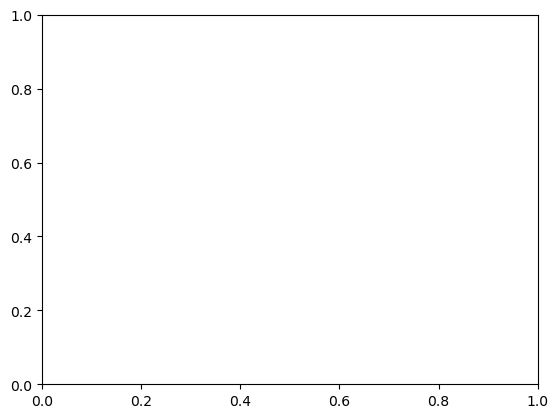

In [146]:
plt.plot(all_eps, delta_recall["BPR"], label="BPR")
plt.plot(all_eps, delta_recall["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_recall["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_recall["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_recall["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta Recall$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

KeyError: 'NeuMF'

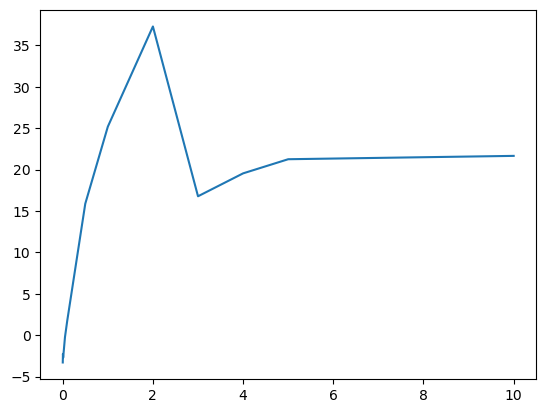

In [174]:
plt.plot(all_eps, delta_ndcg["BPR"], label="BPR")
plt.plot(all_eps, delta_ndcg["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_ndcg["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_ndcg["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_ndcg["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta nDCG$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

KeyError: 'NeuMF'

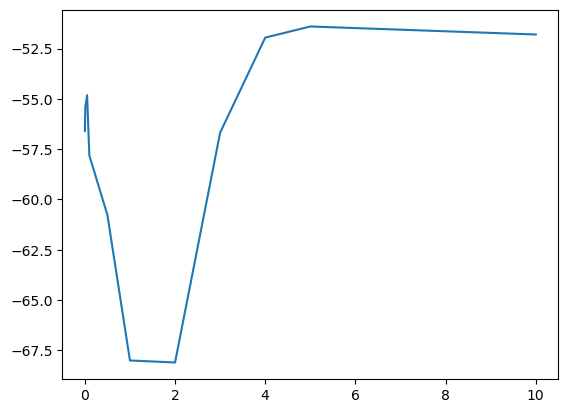

In [175]:
plt.plot(all_eps, delta_arp["BPR"], label="BPR")
plt.plot(all_eps, delta_arp["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_arp["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_arp["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_arp["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ ARP in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

KeyError: 'NeuMF'

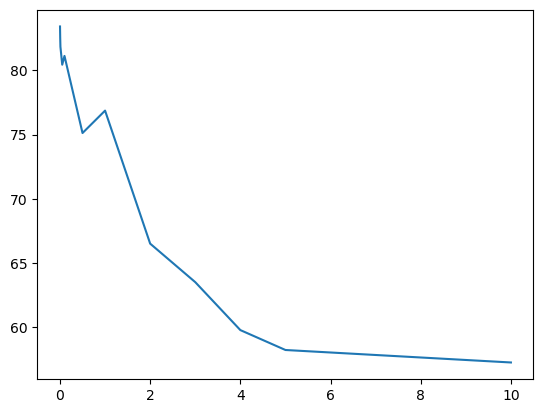

In [176]:
plt.plot(all_eps, delta_aft["BPR"], label="BPR")
plt.plot(all_eps, delta_aft["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_aft["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_aft["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_aft["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ AFT in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

KeyError: 'NeuMF'

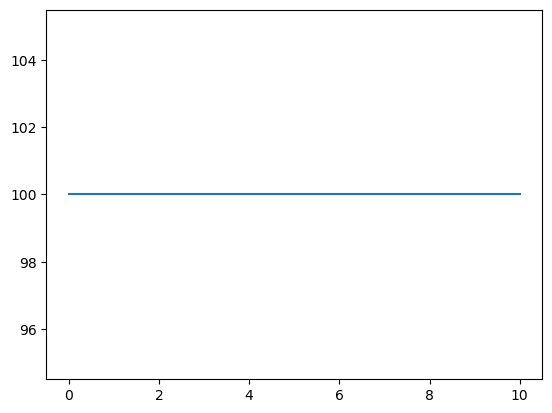

In [177]:
plt.plot(all_eps, no_users["BPR"], label="BPR")
plt.plot(all_eps, no_users["NeuMF"], label="NeuMF")
plt.plot(all_eps, no_users["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, no_users["LightGCN"], label="LightGCN")
#plt.plot(all_eps, no_users["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("No. Users in %")
plt.gca().invert_xaxis()
plt.legend()

KeyError: 'NeuMF'

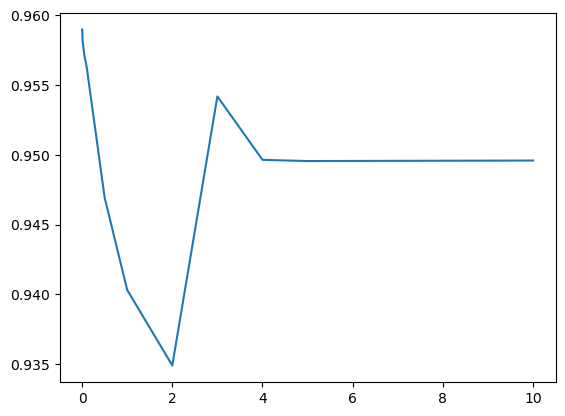

In [178]:
plt.plot(all_eps, jacc_dist["BPR"], label="BPR")
plt.plot(all_eps, jacc_dist["NeuMF"], label="NeuMF")
plt.plot(all_eps, jacc_dist["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, jacc_dist["LightGCN"], label="LightGCN")
#plt.plot(all_eps, jacc_dist["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("Avg. Jaccard Distance")
plt.gca().invert_xaxis()
plt.legend()

In [169]:
dataset_name = "ml-1m"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
test_df["user_id"] = test_df["user_id"].astype(str)
test_df["item_id"] = test_df["item_id"].astype(str)

groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())

frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"

cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

In [188]:
def analyze_groups(dataset_name, model_name, groundtruth, item_popularity, group1, group2):
    def get_deltas(results_nodp, results_dp):
        recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_dp

        delta_recall_eps, delta_ndcg_eps, delta_arp_eps, delta_aft_eps = [], [], [], []
        for file_idx in range(5):
            intersection = set(recall_nodp[file_idx].keys()).intersection(recall_eps[file_idx].keys())
            delta_recall_eps_f, delta_ndcg_eps_f, delta_arp_eps_f, delta_aft_eps_f = [], [], [], []
            for uid in intersection:
                delta_recall_eps_f.append((recall_eps[file_idx][uid] - recall_nodp[file_idx][uid]) / recall_nodp[file_idx][uid] if recall_nodp[file_idx][uid] != 0 else np.nan)
                delta_ndcg_eps_f.append((ndcg_eps[file_idx][uid] - ndcg_nodp[file_idx][uid]) / ndcg_nodp[file_idx][uid] if ndcg_nodp[file_idx][uid] != 0 else np.nan)
                delta_arp_eps_f.append((arp_eps[file_idx][uid] - arp_nodp[file_idx][uid]) / arp_nodp[file_idx][uid] if arp_nodp[file_idx][uid] != 0 else np.nan)
                delta_aft_eps_f.append((aft_eps[file_idx][uid] - aft_nodp[file_idx][uid]) / aft_nodp[file_idx][uid] if aft_nodp[file_idx][uid] != 0 else np.nan)
            delta_recall_eps.append(100 * np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(100 * np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(100 * np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(100 * np.nanmean(delta_aft_eps_f))

        return np.mean(delta_recall_eps), np.mean(delta_ndcg_eps), np.mean(delta_arp_eps), np.mean(delta_aft_eps)

    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)

    delta_recall, delta_ndcg, delta_arp, delta_aft = [], [], [], []
    for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]:
        users, _, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(group1))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(group2))

        results1_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=group1_and_impacted)
        results2_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=group2_and_impacted)

        delta_recall1, delta_ndcg1, delta_arp1, delta_aft1 = get_deltas(results_nodp=results_nodp, results_dp=results1_eps)
        delta_recall2, delta_ndcg2, delta_arp2, delta_aft2 = get_deltas(results_nodp=results_nodp, results_dp=results2_eps)

        print("eps: %f -> %.2f%%/%.2f%% (recall), %.2f%%/%.2f%% (ndcg), %.2f%%/%.2f%% (arp), %.2f%%/%.2f%% (aft)" % (eps, delta_recall1, delta_recall2, delta_ndcg1, delta_ndcg2, delta_arp1, delta_arp2, delta_aft1, delta_aft2))

    print()
    return None

analyze_groups(dataset_name=dataset_name, model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users)

eps: 10.000000 -> -7.09%/-2.02% (recall), -2.38%/0.91% (ndcg), -13.06%/-3.36% (arp), 26.78%/nan% (aft)


C:\Users\pmuellner\AppData\Local\Temp\ipykernel_21776\1931061534.py:18: RuntimeWarning: Mean of empty slice
  delta_aft_eps.append(100 * np.nanmean(delta_aft_eps_f))


eps: 5.000000 -> -6.72%/-3.57% (recall), -1.49%/-0.24% (ndcg), -8.73%/-2.17% (arp), 16.13%/nan% (aft)
eps: 4.000000 -> -13.55%/-5.95% (recall), -7.54%/-2.74% (ndcg), 35.38%/1.29% (arp), -28.37%/nan% (aft)
eps: 3.000000 -> -15.62%/-9.70% (recall), -12.34%/-7.75% (ndcg), 39.36%/1.97% (arp), -21.18%/nan% (aft)
eps: 2.000000 -> -11.14%/-8.01% (recall), -5.35%/-4.56% (ndcg), 8.40%/-2.03% (arp), -34.19%/nan% (aft)
eps: 1.000000 -> -22.17%/-12.82% (recall), -15.40%/-9.46% (ndcg), 76.29%/3.66% (arp), -75.37%/nan% (aft)
eps: 0.500000 -> -24.87%/-17.84% (recall), -19.25%/-15.69% (ndcg), 77.79%/2.50% (arp), -83.96%/nan% (aft)
eps: 0.100000 -> -30.58%/-21.38% (recall), -24.68%/-19.07% (ndcg), 106.65%/4.33% (arp), -80.17%/nan% (aft)
eps: 0.050000 -> -32.24%/-20.66% (recall), -28.23%/-18.40% (ndcg), 106.52%/5.25% (arp), -88.49%/nan% (aft)
eps: 0.010000 -> -33.02%/-19.95% (recall), -27.09%/-16.56% (ndcg), 113.09%/3.88% (arp), -77.89%/nan% (aft)
eps: 0.005000 -> -31.58%/-20.37% (recall), -26.24%/-17.5

In [ ]:
user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))

In [ ]:
def _compute_delta_gap(recommendation_list, item_popularity, user_profile_pop, impacted_users=None):
    gap = []
    for uid, recs in recommendation_list.items():
        if impacted_users is not None:
            if uid not in impacted_users:
                continue

        arp_u = np.mean([item_popularity.loc[item_id] for item_id in recs])
        gap.append((arp_u - user_profile_pop.loc[int(uid)]) / user_profile_pop.loc[int(uid)])


    return np.mean(gap)

def analyze_delta_gap(dirpath, item_popularity, user_profile_popularity, impacted_users=None):
    files = sort_files(dirpath)
    gaps = []
    #for file in os.listdir(dirpath):
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            gap = _compute_delta_gap(recommendation_list, item_popularity, user_profile_popularity, impacted_users=impacted_users[idx])
        else:
            gap = _compute_delta_gap(recommendation_list, item_popularity, user_profile_popularity)
        gaps.append(gap)

    return 100 * np.nanmean(gaps)